# Data Science project 2, Ecommerce Dataset

## ML6, Integrify

### Hannu Kiiskinen, 23.11.2023

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import f, f_oneway
from scipy.stats import chi2_contingency
from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px

## Descriptive statistics

### Dataset

Ecommerce Dataset from Kaggle. Data collected 6 years ago, not updated after that.

License: CC0, Puplic Domain

In [2]:
df = pd.read_csv("DS_Project2a/data-2.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data review

541909 entries, 8 columns, float, int and object data types, there are missing values in two fields (Description and CustomerID).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

### Distribution of data

In [5]:
df1 = df.filter(items=['Quantity', 'UnitPrice']) # Just include numeric values
df1.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Factors (meaning of the columns)

- InvoiceNo, Number related to Customer Invoicing
- StockCode, Code used in Stock
- Description, description of the item
- Quantity, amount of items
- InvoiceDate, Date when items are Invoiced
- UnitPrice, unit price of the item
- CustomerID, Id for each Customer
- Country, Country of customer

## Explotary Data Analysis

<AxesSubplot:>

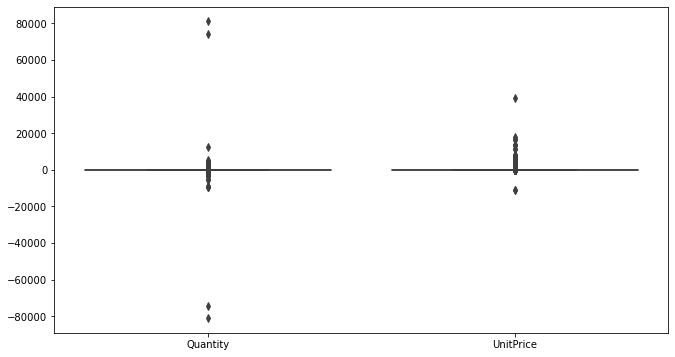

In [9]:
# Boxplot to show outliers, just numerical values
plt.figure(figsize=(11, 6))
sns.boxplot(data=df1)

### Clean the data

- Outliers shown in BoxPlot (only for continues = Quantity and UnitPrice)
- Missing values in Description and CustomerID
- Strange values in Quantity and UnitPrice (negative)
    - There are two negative values in UnitPrice, which are "Adjust bad debt"
    - There are lot of negative values in Quantity, these have to be evaluated separately if interesting?
    - Negative values will be removed for following processing and it is possible to evaluate negative Qty separately

In [10]:
# Amount of missing values & Percentage of missing values
mis_des = df['Description'].isna().sum()
mis_cid = df['CustomerID'].isna().sum()
all_val = df.shape[0]
print(f'Amount of missing Description values = {mis_des}, percentage is {(100*mis_des/all_val).round(1)} %')
print(f'Amount of missing CustomerID values = {mis_cid}, percentage is {(100*mis_cid/all_val).round(1)} %')
print()

# Amount of negative values
neg_qty = df[df['Quantity'] < 0].shape[0]
neg_pri = df[df['UnitPrice'] < 0].shape[0]
print(f'Negative Quantity values = {neg_qty}, percentage is {round((100*neg_qty/all_val), 1)} %')
print(f'Negative UnitPrice values = {neg_pri}, percentage is {round((100*neg_pri/all_val), 1)} %')

Amount of missing Description values = 1454, percentage is 0.3 %
Amount of missing CustomerID values = 135080, percentage is 24.9 %

Negative Quantity values = 10624, percentage is 2.0 %
Negative UnitPrice values = 2, percentage is 0.0 %


#### Removing data from analysis

There are small amount negative values and also small amount missing Descriptions which will be deleted.

The amount of missing CutomerID is bigger, but as this is useless when analyicing who is bying what, also these will be deleted.

There are also some Postage and Manual costs, which are not directly related to Customer, so also these will be deleted.

In [11]:
# Delete rows with negative values, NaN-values and some other selected uninterested values (Postage & Manual)
df_pos = df.drop(df[df.Quantity < 0].index)                    # Negative Quantity
df_pos = df_pos.drop(df_pos[df_pos.UnitPrice < 0].index)       # Negative UnitPrice
df_pos = df_pos.drop(df_pos[df_pos.StockCode == 'POST'].index) # Postage
df_pos = df_pos.drop(df_pos[df_pos.StockCode == 'M'].index)    # Manual
df_pos = df_pos.drop(df_pos[df_pos.StockCode == 'DOT'].index)  # DotCom Postage
df_pos = df_pos.dropna()
df_pos.shape, df.shape

((396519, 8), (541909, 8))

### Transformation

- Adding Total amount of money used in new field

In [12]:
# Calculate Total = Qty * UnitPrice

total = df_pos.Quantity * df_pos.UnitPrice
df_pos['Total'] = total
df_pos

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60


### Data visualization and Relationships between factors

There are some additional task needed to do to get better visualization results.

In [13]:
# Reorder the fields for visualization
df_vis = df_pos[['InvoiceNo', 'StockCode', 'InvoiceDate', 'CustomerID', 'Country', 'Description', 'Quantity', 'UnitPrice', 'Total']]

# Split the data for visualization purposes for High and Low values
df_vis_High = df_vis.drop(df_vis[df_vis.Total < 400].index)      # Remove extremely high total values
df_vis_Low = df_vis.drop(df_vis[df_vis.Total > 400].index)       # Remove extremely low total values
df_vis_High.shape, df_vis_Low.shape

((1229, 9), (395293, 9))

In [14]:
app = Dash(__name__)

app.layout = html.Div(children=[
#    html.H3(children='Ecommerce Dataset'),

    html.Label("Select Feature1"),
    dcc.Dropdown(
        id='target-variable',
        options=[{'label': col, 'value': col} for col in df_vis.columns[:-3]],
        value=df_vis.columns[4]
    ),
    # Dropdown for selecting the feature to visualize
    html.Label("Select Feature2"),
    dcc.Dropdown(
        id='feature-variable',
        options=[{'label': col, 'value': col} for col in df_vis.columns[6:]],  # Exclude the target variable
        value=df_vis.columns[6]
    ),
    # Radio buttons for selecting visualization type
    html.Label("Select The part of Dataset"),
    dcc.RadioItems(
        id='visualization-type',
        options=[
            {'label': 'Higher values', 'value': 'df_vis_High'},
            {'label': 'Lower values', 'value': 'df_vis_Low'}
        ],
        value='df_vis_High',
        labelStyle={'display': 'block'}
    ),
    # Graph container
    dcc.Graph(id='graph')
])
# Callback to update the graph based on user input
@app.callback(
    Output('graph', 'figure'),
    [Input('target-variable', 'value'),
     Input('feature-variable', 'value'),
     Input('visualization-type', 'value')]
)
def update_graph(target_var, feature_var, vis_type):
    #df1 = df.loc[(df['UnitPrice'] < 10)]
    if vis_type == 'df_vis_High':
        df1 = df_vis_High
    else:
        df1 = df_vis_Low
    fig = px.scatter(df1, x=feature_var, y=target_var, color="Country", hover_name="Description")
    return fig

if __name__ == '__main__':
    app.run(debug=True)

### Top items
- Highest money maker: PAPER CRAFT , LITTLE BIRDIE, Total = 168469.6
- The most costly item: PICNIC BASKET WICKER 60 PIECES, UnitPrice = 649.5
- The biggest quantity: PAPER CRAFT , LITTLE BIRDIE, Quantity = 80995

In [12]:
df_pos.sort_values(by=['Total'], ascending=False).head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.50,15098.0,United Kingdom,38970.0


In [13]:
df_pos.sort_values(by=['UnitPrice'], ascending=False).head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.5,15098.0,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,6/10/2011 15:33,649.5,15098.0,United Kingdom,649.5
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,3/25/2011 14:19,295.0,13452.0,United Kingdom,295.0


In [14]:
df_pos.sort_values(by=['Quantity'], ascending=False).head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256.0,United Kingdom,0.0


### The most bough, sold, stoked, invoiced (sorted by Total)
- Customer who buys the most: CustomerID = 14646, Country = Netherlands, Total = 279138.02
- Country which buys the most: Country = United Kingdom, Total = 7 267 502.00
- The Stock item sold most: StockCode = 23843, UnitPrice = 2.08, Total = 168469.60  (Same item: PAPER CRAFT , LITTLE BIRDIE)
- The InvoiceNo with highest total: InvoiceNo = 581483, Total = 168469.6            (Same item: PAPER CRAFT , LITTLE BIRDIE)
- The most selling (based on Invoice Date) day: 2011-12-09, Total = 184190.28
- The least selling (based on Invoice Date) day: 2011-02-06, Total = 3457.11

In [15]:
df_pos.groupby(['CustomerID']).sum().sort_values(by=['Total'], ascending=False).head(3)

,Quantity,UnitPrice,Total
CustomerID,,,
14646.0,197420,4933.09,279138.02
18102.0,64124,1940.92,259657.30
17450.0,69993,1143.32,194550.79


In [16]:
df_pos.groupby(['Country']).sum().sort_values(by=['Total'], ascending=False).head(3)

,Quantity,UnitPrice,CustomerID,Total
Country,,,,
United Kingdom,4262281,1.013186e+06,5.506329e+09,7.267502e+06
Netherlands,200834,5.686730e+03,3.357626e+07,2.838893e+05
EIRE,140523,2.880494e+04,1.066949e+08,2.621716e+05


In [17]:
df_pos.groupby(['StockCode']).sum().sort_values(by=['Total'], ascending=False).head(3)

,Quantity,UnitPrice,CustomerID,Total
StockCode,,,,
23843,80995,2.08,16446.0,168469.60
22423,12412,21508.90,25806890.0,142592.95
85123A,36782,5887.47,31667793.0,100603.50


In [18]:
df_pos.groupby(['InvoiceNo']).sum().sort_values(by=['Total'], ascending=False).head(3)

,Quantity,UnitPrice,CustomerID,Total
InvoiceNo,,,,
581483,80995,2.08,16446.0,168469.6
541431,74215,1.04,12346.0,77183.6
556444,60,649.50,15098.0,38970.0


In [19]:
# Remove the time to check the most selling date
df_pos['InvoiceDate'] = pd.to_datetime(df_pos['InvoiceDate'])
df_pos['InvoiceDate'] = df_pos['InvoiceDate'].dt.floor('d')
df_pos['InvoiceDate'] = df_pos['InvoiceDate'].dt.normalize()
df_pos.groupby(['InvoiceDate']).sum().sort_values(by=['Total'], ascending=False).head(3)

,Quantity,UnitPrice,CustomerID,Total
InvoiceDate,,,,
2011-12-09,90573,1449.75,8944048.0,184190.28
2011-09-20,42507,4171.39,22271634.0,103338.46
2011-01-18,80584,1611.18,8079356.0,87160.71


In [20]:
# Check the least selling date
df_pos.groupby(['InvoiceDate']).sum().sort_values(by=['Total'], ascending=True).head(3)

,Quantity,UnitPrice,CustomerID,Total
InvoiceDate,,,,
2011-02-06,2048,799.45,4357107.0,3457.11
2011-03-13,2722,1348.36,8227319.0,4100.04
2010-12-22,3071,618.09,3259191.0,4841.52


<AxesSubplot:xlabel='InvoiceDate', ylabel='Total'>

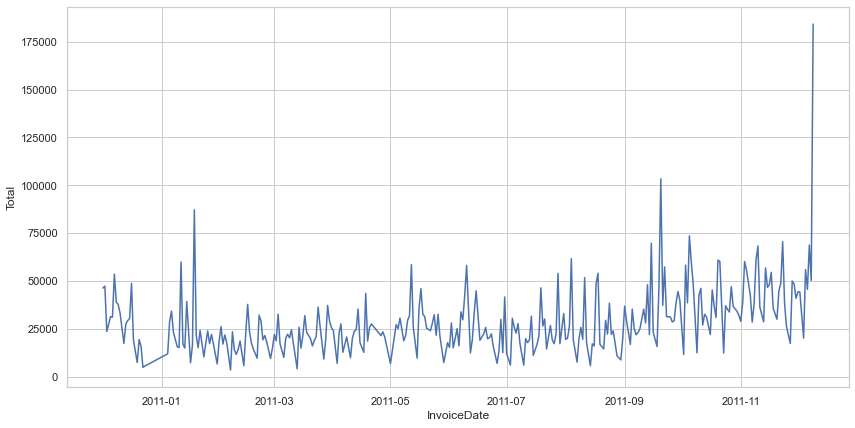

In [46]:
# Plot the history of Total purchases in timeline
df_draw = df_pos.groupby(['InvoiceDate']).sum().sort_values(by=['InvoiceDate'], ascending=True)
df_draw = df_draw.filter(items=['Total', 'InvoiceDate'])
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_draw, x="InvoiceDate", y="Total")

## Research question 1

Take a viewpoint of webshop manager and make valuable insights for him/her.

### Is there a relationship between Country of Customer and Total sum of purchase?

#### Hypothesis definition

H0: There is a significant difference in means between Countries and Total sum of purchase

H1: There are no significant difference in means between Countries and Total sum of purchase

### Test selection

Country is Categorical and Total, UnitPrice and Quantity are numeric, so Anova-test will be used.

In [16]:
def Evaluate_Countries(Country1, Country2, Factor):
    # Data
    df_eva1 = df_pos.loc[(df_pos['Country'] == Country1)][['Total']]['Total']
    df_eva2 = df_pos.loc[(df_pos['Country'] == Country2)][['Total']]['Total']
    #print(f'{Country1}: {df_eva1}')
    #print(f'{Country2}: {df_eva2}')
    
    # Using Anova test, test the hypothesis
    F_Stat, p_value = f_oneway(df_eva1, df_eva2)

    # interpret p-value
    alpha = 0.05
    print(f"\nF_statistics: {round(F_Stat, 1)}, Significance Level (alpha): {alpha}, p-value: {round(p_value, 2)}")

    if p_value <= alpha:
        print(f'Reject H0, There are a significant difference in means in {Factor} between {Country1} and {Country2}.')
    else:
        print(f'Accept H0, There are no significant difference in means in {Factor} between {Country1} and {Country2}.')

In [17]:
Evaluate_Countries('United Kingdom', 'Japan', 'Total')


F_statistics: 27.9, Significance Level (alpha): 0.05, p-value: 0.0
Reject H0, There are a significant difference in means in Total between United Kingdom and Japan.


In [18]:
Evaluate_Countries('Sweden', 'Japan', 'Total')


F_statistics: 3.4, Significance Level (alpha): 0.05, p-value: 0.07
Accept H0, There are no significant difference in means in Total between Sweden and Japan.


### Result of test

There are countries which have significant difference in means in Total, like United Kingdom and Japan.

There are countries which have not significant difference in means in Total, like Sweden and Japan.

## Research question 2a

### Is there a relationship between Country of Customer and UnitPrice of purchased Items?

#### Hypothesis definition

H0: There is a significant difference in means between Countries and UnitPrice of purchased items

H1: There are no significant difference in means between Countries and UnitPrice of purchased items

In [19]:
Evaluate_Countries('United Kingdom', 'Japan', 'UnitPrice')


F_statistics: 27.9, Significance Level (alpha): 0.05, p-value: 0.0
Reject H0, There are a significant difference in means in UnitPrice between United Kingdom and Japan.


In [20]:
Evaluate_Countries('United Kingdom', 'Poland', 'UnitPrice')


F_statistics: 0.0, Significance Level (alpha): 0.05, p-value: 0.96
Accept H0, There are no significant difference in means in UnitPrice between United Kingdom and Poland.


## Research question 2b

### Is there a relationship between Country of Customer and Quantity of purchased Items?

#### Hypothesis definition

H0: There is a significant difference in means between Countries and Quantity of purchased items

H1: There are no significant difference in means between Countries and Quantity of purchased items

In [21]:
Evaluate_Countries('United Kingdom', 'Japan', 'Quantity')


F_statistics: 27.9, Significance Level (alpha): 0.05, p-value: 0.0
Reject H0, There are a significant difference in means in Quantity between United Kingdom and Japan.


In [22]:
Evaluate_Countries('United Kingdom', 'France', 'Quantity')


F_statistics: 0.4, Significance Level (alpha): 0.05, p-value: 0.51
Accept H0, There are no significant difference in means in Quantity between United Kingdom and France.


### Result of tests 2a and 2b

As tests will show, there are possible to find both, Countries where are differences means of UnitPrice and Countries where are not.

As tests will show, there are possible to find both, Countries where are differences means of Quantity and Countries where are not.